In [5]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path('..').resolve()
print('Project root:', project_root)

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.data.load_fraud_data import load_fraud_data
from uais.features.fraud_features import build_fraud_feature_table


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


## Load fraud datasets (creditcard + PaySim)
We load each dataset separately to avoid mixing schemas.

In [6]:
creditcard_path = project_root / 'data' / 'raw' / 'fraud' / 'creditcard.csv'
paysim_path = project_root / 'data' / 'raw' / 'fraud' / 'paysim' / 'paysim_transactions.csv'

creditcard_df = load_fraud_data(creditcard_path)
paysim_df = load_fraud_data(paysim_path)

print('Creditcard shape:', creditcard_df.shape)
print('PaySim shape:', paysim_df.shape)


Creditcard shape: (284807, 31)
PaySim shape: (6362620, 11)


In [7]:
print('Creditcard class balance:')
print(creditcard_df['Class'].value_counts())
print('Fraud ratio:', creditcard_df['Class'].mean())

if 'isFraud' in paysim_df.columns:
    print('PaySim fraud balance (isFraud):')
    print(paysim_df['isFraud'].value_counts())
    print('Fraud ratio:', paysim_df['isFraud'].mean())


Creditcard class balance:
Class
0    284315
1       492
Name: count, dtype: int64
Fraud ratio: 0.001727485630620034
PaySim fraud balance (isFraud):
isFraud
0    6354407
1       8213
Name: count, dtype: int64
Fraud ratio: 0.001290820448180152


## Data cleaning (creditcard + PaySim)
Basic hygiene: drop duplicates, standardize column names, and fill missing values.

In [8]:
def clean_df(df, target_col=None):
    df = df.copy()
    # Standardize column names to lowercase
    df.columns = [c.strip() for c in df.columns]
    before = len(df)
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Dropped {before - len(df)} duplicates")
    # Simple missing handling: numeric median fill, categorical mode fill
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    if num_cols:
        df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    for col in cat_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].mode().iloc[0])
    # Ensure target column is kept intact if provided
    if target_col and target_col in df.columns:
        df[target_col] = df[target_col].astype(int)
    return df

creditcard_df = clean_df(creditcard_df, target_col='Class')
paysim_df = clean_df(paysim_df, target_col='isFraud' if 'isFraud' in paysim_df.columns else None)
print('Cleaned creditcard:', creditcard_df.shape)
print('Cleaned PaySim:', paysim_df.shape)


Dropped 1081 duplicates
Dropped 0 duplicates
Cleaned creditcard: (283726, 31)
Cleaned PaySim: (6362620, 11)


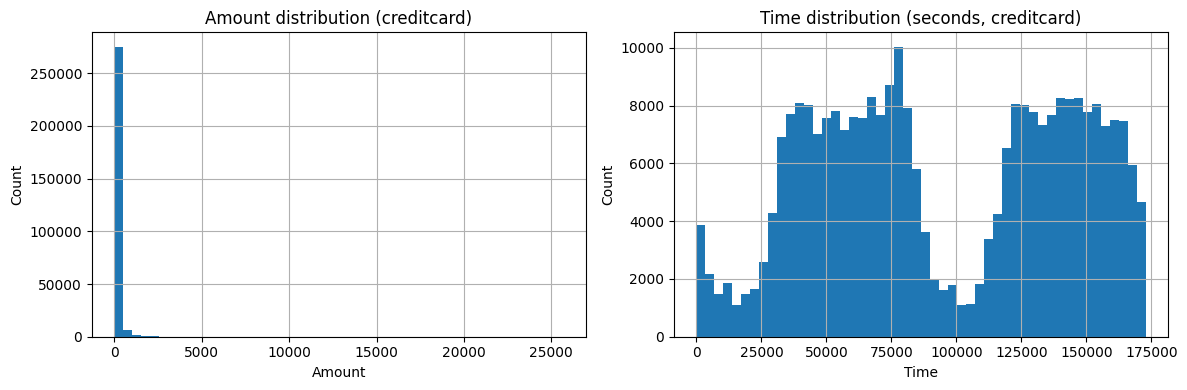

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
creditcard_df['Amount'].hist(ax=axes[0], bins=50)
axes[0].set_title('Amount distribution (creditcard)')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Count')

creditcard_df['Time'].hist(ax=axes[1], bins=50)
axes[1].set_title('Time distribution (seconds, creditcard)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


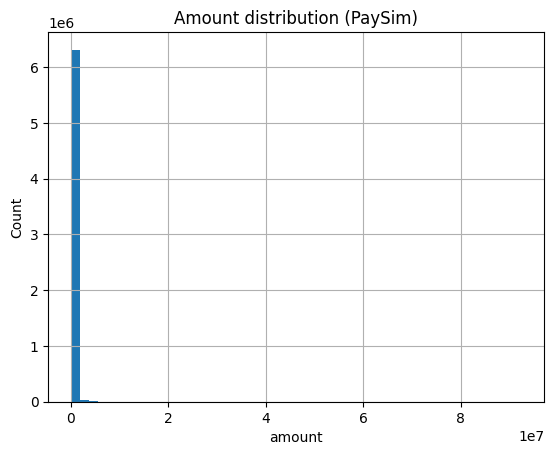

In [10]:
# PaySim: amount/time overview
if 'amount' in paysim_df.columns:
    paysim_df['amount'].hist(bins=50)
    plt.title('Amount distribution (PaySim)')
    plt.xlabel('amount')
    plt.ylabel('Count')
    plt.show()


In [11]:
creditcard_feats = build_fraud_feature_table(
    creditcard_df,
    time_column='Time',
    amount_column='Amount',
    target_column='Class',
    drop_original_time=False,
)

print('Creditcard feature table shape:', creditcard_feats.shape)
creditcard_feats.head()


Creditcard feature table shape: (283726, 35)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,amount_log,time_hours,time_seconds_mod_day,hour_of_day
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.014760,0.000000,0.0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,0,1.305626,0.000000,0.0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.939276,0.000278,1.0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.824306,0.000278,1.0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.262539,0.000556,2.0,0


In [12]:
# Save creditcard features
processed_dir = project_root / 'data' / 'processed' / 'fraud'
processed_dir.mkdir(parents=True, exist_ok=True)
feats_path = processed_dir / 'fraud_features.parquet'
creditcard_feats.to_parquet(feats_path)
print('Saved creditcard feature table to:', feats_path)


Saved creditcard feature table to: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/data/processed/fraud/fraud_features.parquet


## Train/test split on creditcard
Using the engineered features to train a simple model.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import HistGradientBoostingClassifier

# Split
X = creditcard_feats.drop(columns=['Class'])
y = creditcard_feats['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train a quick model
clf = HistGradientBoostingClassifier(max_depth=4, learning_rate=0.1, max_iter=200)
clf.fit(X_train, y_train)

probs = clf.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5).astype(int)
print('ROC-AUC:', roc_auc_score(y_test, probs))
print('F1:', f1_score(y_test, preds))


ROC-AUC: 0.8421492071956737
F1: 0.7294117647058823
